In [13]:
import pymc as pm
import numpy as np
from datetime import datetime
import arviz as az

In [14]:
import pandas as pd
import glob
import os
import re

# Folder where your files are
folder = "../data/processed"

# Pattern to match 'hmm_<asset>' at the start of the filename
pattern = re.compile(r'hmm_([A-Za-z0-9]+)')

# Find all CSV files starting with "hmm_"
files = glob.glob(os.path.join(folder, "hmm_*.csv"))

returns_l = []

for file in files:
    filename = os.path.basename(file)
    match = pattern.match(filename)
    if match:
        asset = match.group(1)
        df = pd.read_csv(
            file,
            index_col=0,       # use first column as index
            parse_dates=True   # parse index as datetime if possible
        )
        
        returns_l.append(df[f"{asset}_ret"])

returns = (
    pd.concat(returns_l, axis=1)
)
returns = returns.reset_index().rename(columns={'index': 'Date'})

In [15]:
portfolio_hmm = pd.read_csv("../data/processed/portfolio_hmm.csv")
z_week7 = portfolio_hmm[['Date','regime']] 

In [16]:
returns['Date'] = pd.to_datetime(returns['Date'])
z_week7['Date'] = pd.to_datetime(z_week7['Date'])

/var/folders/28/dj3nmc0d5wn_x5d6qp7g64f80000gn/T/ipykernel_26663/306342098.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  z_week7['Date'] = pd.to_datetime(z_week7['Date'])


In [17]:
num_assets = returns.shape[1]

# Pre-compute regime stats from Week-7
hmm_df = pd.merge(returns, z_week7, on='Date', how='inner')

(15,) (15, 15)

CLASSICAL SHARPE-MAX WEIGHTS

Regime 0 (Low Vol) Optimal Weights:
  QQQ :  -6.0%
  BA  :  -1.0%
  AAPL:   4.6%
  PEP :   0.8%
  KO  :   0.4%
  TSLA:   0.6%
  BND :  87.2%
  GC  :   2.7%
  NVDA:   5.7%
  JNJ :   7.4%
  MSFT:   5.5%
  TLT : -17.9%
  CL  :  -0.0%
  SPY :  -0.0%
  JPM :  10.1%

Regime 1 (High Vol) Optimal Weights:
  QQQ :  -6.4%
  BA  :  -0.3%
  AAPL:  -1.2%
  PEP :  -2.0%
  KO  :   5.6%
  TSLA:   1.0%
  BND :   8.9%
  GC  :  97.9%
  NVDA:   1.1%
  JNJ :  -2.8%
  MSFT:   4.1%
  TLT :  -5.3%
  CL  :   1.8%
  SPY :   0.0%
  JPM :  -2.2%

Regime 0 Sharpe: 0.202 (annualized: 3.20)
Regime 1 Sharpe: 0.068 (annualized: 1.07)

BACKTEST RESULTS (Annualized)
Dynamic Portfolio:  Sharpe 2.684, Vol 3.6%
Equal-Weight Bench: Sharpe 0.904,    Vol 15.7%
Outperformance:     ++1.780 Sharpe


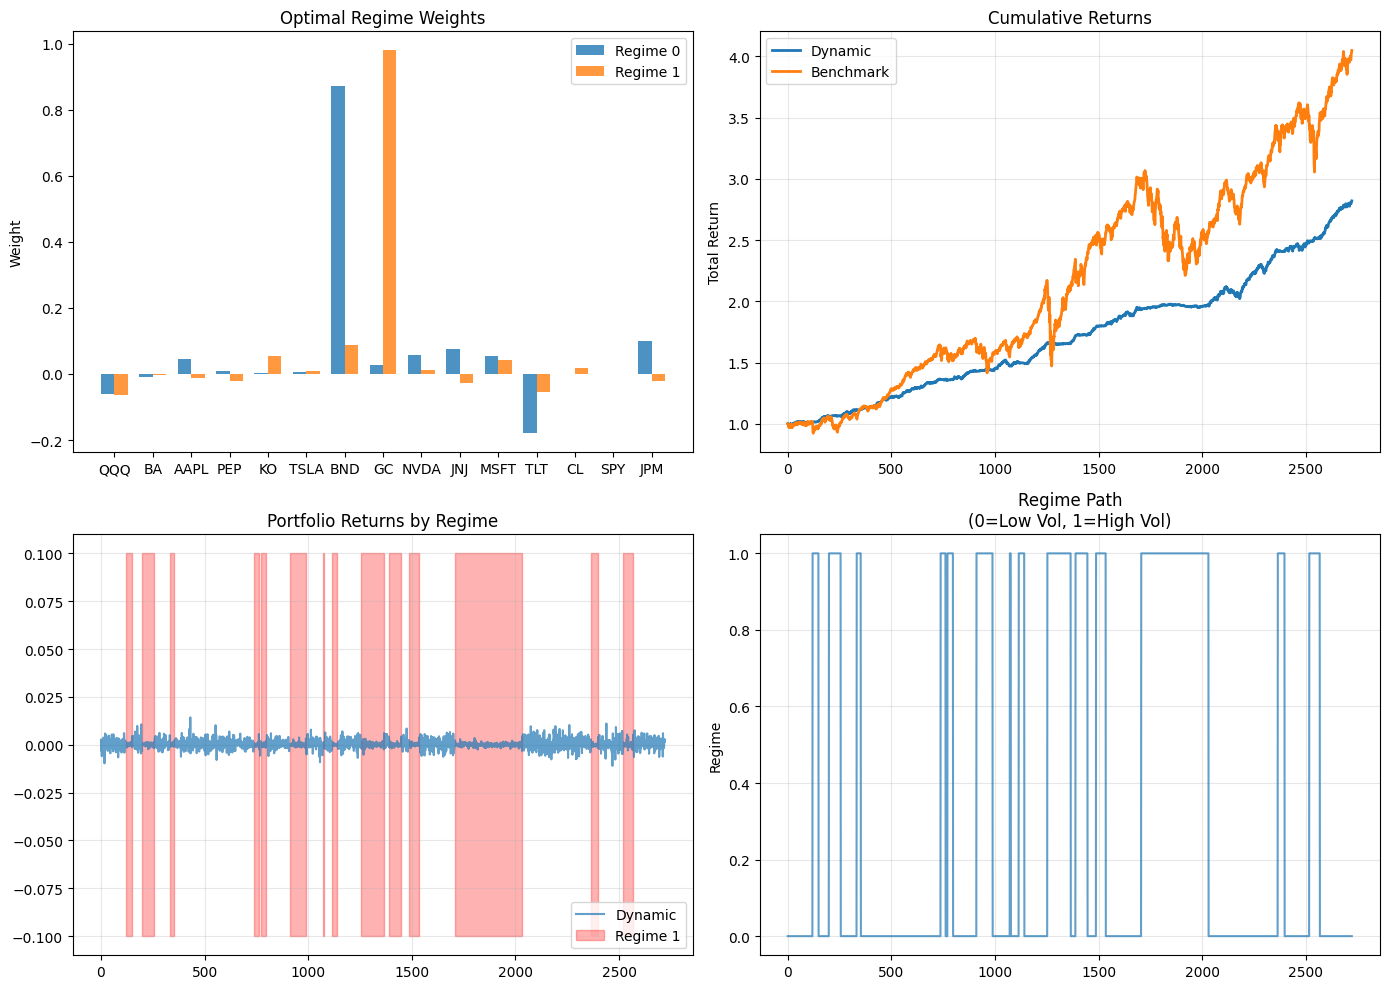

In [18]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize

hmm_df = hmm_df.sort_index()                     # ensure ordered
assert "regime" in hmm_df.columns

ret_cols = [c for c in hmm_df.columns if c.endswith("_ret")]
asset_names = [c.replace("_ret", "") for c in ret_cols]
asset_returns_df = hmm_df[ret_cols]           # shape (T, N)
asset_returns = asset_returns_df.values
z_regimes = hmm_df["regime"].to_numpy()

T, N = asset_returns_df.shape

regime0_mask = (z_regimes == 0)
regime1_mask = (z_regimes == 1)

mu_reg0 = asset_returns_df[regime0_mask].mean(axis=0).to_numpy()    # (N,)
mu_reg1 = asset_returns_df[regime1_mask].mean(axis=0).to_numpy()    # (N,)
Sigma_reg0 = asset_returns_df[regime0_mask].cov().to_numpy()        # (N,N)
Sigma_reg1 = asset_returns_df[regime1_mask].cov().to_numpy()        # (N,N)

print(mu_reg0.shape, Sigma_reg0.shape)

# =============================================================================
# 3. CLASSICAL SHARPE MAX OPTIMIZATION
# =============================================================================
def neg_sharpe(w, mu, Sigma):
    port_mu = w @ mu
    port_var = w @ Sigma @ w
    return - (port_mu / np.sqrt(port_var)) if port_var > 0 else 1e6

# Constraints: sum(w) = 1, w >= 0
max_gross = 1.5  # e.g. |w| sum ≤ 1.5

constraints = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},                 # net = 1
    {'type': 'ineq', 'fun': lambda w: max_gross - np.sum(np.abs(w))}  # |w| sum ≤ max_gross
)

bounds = [(-1, 1)] * N


# Optimize each regime
w_reg0_opt = minimize(
    neg_sharpe,
    x0=np.ones(N)/N,
    args=(mu_reg0, Sigma_reg0),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
).x

w_reg1_opt = minimize(
    neg_sharpe,
    x0=np.ones(N)/N,
    args=(mu_reg1, Sigma_reg1),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
).x

# =============================================================================
# 4. RESULTS
# =============================================================================
print("\n" + "="*60)
print("CLASSICAL SHARPE-MAX WEIGHTS")
print("="*60)

print("\nRegime 0 (Low Vol) Optimal Weights:")
for i, name in enumerate(asset_names):
    print(f"  {name:4s}: {w_reg0_opt[i]:6.1%}")

print("\nRegime 1 (High Vol) Optimal Weights:")
for i, name in enumerate(asset_names):
    print(f"  {name:4s}: {w_reg1_opt[i]:6.1%}")

# Regime Sharpe ratios
sharpe_reg0 = (w_reg0_opt @ mu_reg0) / np.sqrt(w_reg0_opt @ Sigma_reg0 @ w_reg0_opt)
sharpe_reg1 = (w_reg1_opt @ mu_reg1) / np.sqrt(w_reg1_opt @ Sigma_reg1 @ w_reg1_opt)
print(f"\nRegime 0 Sharpe: {sharpe_reg0:.3f} (annualized: {sharpe_reg0*np.sqrt(252):.2f})")
print(f"Regime 1 Sharpe: {sharpe_reg1:.3f} (annualized: {sharpe_reg1*np.sqrt(252):.2f})")

# =============================================================================
# 5. BACKTEST
# =============================================================================
port_ret_dynamic = np.zeros(T)
for t in range(T):
    w_t = w_reg0_opt if z_regimes[t] == 0 else w_reg1_opt
    port_ret_dynamic[t] = w_t @ asset_returns[t]

benchmark_ret = asset_returns.mean(axis=1)

def annual_sharpe(r): 
    return r.mean() / r.std() * np.sqrt(252) if r.std() > 0 else 0

def annual_vol(r): 
    return r.std() * np.sqrt(252)

print("\n" + "="*60)
print("BACKTEST RESULTS (Annualized)")
print("="*60)
print(f"Dynamic Portfolio:  Sharpe {annual_sharpe(port_ret_dynamic):.3f}, Vol {annual_vol(port_ret_dynamic):.1%}")
print(f"Equal-Weight Bench: Sharpe {annual_sharpe(benchmark_ret):.3f},    Vol {annual_vol(benchmark_ret):.1%}")
print(f"Outperformance:     +{annual_sharpe(port_ret_dynamic) - annual_sharpe(benchmark_ret):+.3f} Sharpe")

# =============================================================================
# 6. PLOTS
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Weights comparison
x = np.arange(N)
width = 0.35
axes[0,0].bar(x - width/2, w_reg0_opt, width, label='Regime 0', alpha=0.8)
axes[0,0].bar(x + width/2, w_reg1_opt, width, label='Regime 1', alpha=0.8)
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(asset_names)
axes[0,0].set_ylabel('Weight')
axes[0,0].set_title('Optimal Regime Weights')
axes[0,0].legend()

# Cumulative returns
cum_dynamic = (1 + port_ret_dynamic).cumprod()
cum_bench = (1 + benchmark_ret).cumprod()
axes[0,1].plot(cum_dynamic, label='Dynamic', linewidth=2)
axes[0,1].plot(cum_bench, label='Benchmark', linewidth=2)
axes[0,1].set_title('Cumulative Returns')
axes[0,1].set_ylabel('Total Return')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Portfolio returns by regime
axes[1,0].plot(port_ret_dynamic, alpha=0.7, label='Dynamic')
axes[1,0].fill_between(range(T), -0.1, 0.1, where=(z_regimes==1), 
                      color='red', alpha=0.3, label='Regime 1')
axes[1,0].set_title('Portfolio Returns by Regime')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# Regime path
axes[1,1].plot(z_regimes, alpha=0.7)
axes[1,1].set_title('Regime Path\n(0=Low Vol, 1=High Vol)')
axes[1,1].set_ylabel('Regime')
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("regime_portfolio_results.png", dpi=300, bbox_inches='tight')

In [19]:
def print_key_weights(w0, w1, asset_names, top_k=3):
    # indices of largest |weights|
    idx0 = np.argsort(-np.abs(w0))[:top_k]
    idx1 = np.argsort(-np.abs(w1))[:top_k]

    print("• Regime 0 top weights:")
    for i in idx0:
        print(f"  {asset_names[i]} {w0[i]:.0%}")

    print("• Regime 1 top weights:")
    for i in idx1:
        print(f"  {asset_names[i]} {w1[i]:.0%}")

print_key_weights(w_reg0_opt, w_reg1_opt, asset_names, top_k=3)

• Regime 0 top weights:
  BND 87%
  TLT -18%
  JPM 10%
• Regime 1 top weights:
  GC 98%
  BND 9%
  QQQ -6%


In [20]:
# using your df with asset returns + regime labels
z = hmm_df['regime'].values  # 0 or 1

# dynamic portfolio return series
w_t = np.where(z[:,None]==0, w_reg0_opt, w_reg1_opt)             # (T,5)

In [21]:
# Create FULL weights first (no filtering yet)
w_t = np.where(z_regimes[:,None]==0, w_reg0_opt, w_reg1_opt)  # (2705, N)

weights_df = pd.DataFrame(w_t, index=hmm_df['Date'], columns=asset_names)
weights_df['regime'] = z_regimes

# NOW filter by date
start_date = pd.to_datetime("2025-11-01")
end_date = pd.to_datetime("2025-12-25")

weights_filtered = weights_df[
    (weights_df.index >= start_date) & 
    (weights_df.index <= end_date)
]

# Transpose filtered result
weights_transposed = weights_filtered.T

print(f"Filtered to {len(weights_filtered)} dates")
weights_transposed.to_csv("../data/processed/daily_portfolio_weights.csv")


Filtered to 37 dates


In [22]:
dyn_ret = (w_t * asset_returns_df.values).sum(axis=1)                # (T,)

# equal‑weight benchmark (to mimic your earlier comparison)
bench_ret = asset_returns_df.mean(axis=1)

portfolio_dyn = pd.DataFrame({
    'raw_returns': bench_ret,      # like "Unscaled"
    'scaled_returns': dyn_ret      # your regime‑weighted strategy
}, index=hmm_df.index)

portfolio_dyn.to_csv("../data/processed/portfolio_hmm_dyn.csv")

In [23]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [24]:
from scripts.backtest.backtest_utils import backtest_portfolio

raw_perf = backtest_portfolio(portfolio_dyn.raw_returns)
scaled_perf = backtest_portfolio(portfolio_dyn.scaled_returns)

perf_table = pd.DataFrame(
    [raw_perf, scaled_perf],
    index=["Unscaled (Equal‑Weight)", "Regime‑Weighted"]
)
print(perf_table)


                         Annual Return  Annual Volatility  Sharpe Ratio  \
Unscaled (Equal‑Weight)       0.138118           0.156875      0.880430   
Regime‑Weighted               0.100702           0.036002      2.797139   

                         Max Drawdown  
Unscaled (Equal‑Weight)     -0.321316  
Regime‑Weighted             -0.046011  
